In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import os
import time

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from tqdm import tqdm
import copy
import multiprocessing

# Import custom libraries
from src.classifier import ResNet, Bottleneck
from src.utils import train, test, seed_everything
from src.trainer import Trainer

## Model Instantiated

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
seed_everything(42)

resnet_model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)

resnet_model_exp = copy.deepcopy(resnet_model)
resnet_model_exp = nn.DataParallel(resnet_model_exp)
resnet_model_exp = resnet_model_exp.to(device)

## LR Finder

In [3]:
train_transformation = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomResizedCrop(
                224,
                interpolation=transforms.InterpolationMode.BILINEAR,
                antialias=True,
            ),
            transforms.RandomHorizontalFlip(0.5),
            # Normalize the pixel values (in R, G, and B channels)
            transforms.Normalize(
                mean=[0.485, 0.485, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

train_dataset = torchvision.datasets.ImageFolder(
    root="/home/ec2-user/ebs/volumes/imagenet/ILSVRC/Data/CLS-LOC/train", 
    transform=train_transformation
)
train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    sampler=train_sampler,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.51E-01


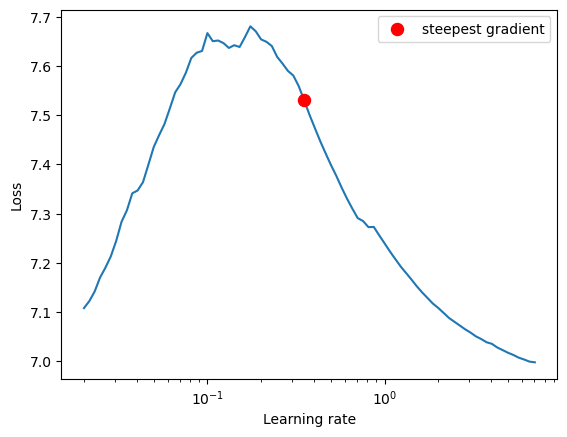

In [5]:
from torch_lr_finder import LRFinder

optimizer = optim.SGD(resnet_model_exp.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

amp_config = {
    'device_type': 'cuda',
    'dtype': torch.float16,
}
grad_scaler = torch.cuda.amp.GradScaler()

lr_finder = LRFinder(
    resnet_model_exp, 
    optimizer, 
    criterion, 
    device='cuda',
    amp_backend='torch', 
    amp_config=amp_config, 
    grad_scaler=grad_scaler
)
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

## Training

In [4]:
## Checking number of cores available
import multiprocessing
multiprocessing.cpu_count()

48

In [5]:
config = {
    "train_path" : "/home/ec2-user/ebs/volumes/imagenet/ILSVRC/Data/CLS-LOC/train",
    "val_path" : "/home/ec2-user/ebs/volumes/imagenet/imagenet_validation",
    "batch_size" : 512,
    "num_workers" : multiprocessing.cpu_count(),
    "epochs" : 100,
    "artifact_path" : "/home/ec2-user/ebs/volumes/era_session9",
    "log_path": "/home/ec2-user/ebs/volumes/era_session9",
}

device = ('cuda' if torch.cuda.is_available() else 'cpu')
seed_everything(42)

optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode="max",
#     factor=0.1,
#     patience=5,
#     verbose=False,
#     threshold_mode='rel',
#     threshold=0.0001,
#     min_lr=1e-6,
# )
# scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [6]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.351,
    epochs=config["epochs"], 
    steps_per_epoch=len(train_loader),
    pct_start=0.3, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=25.0, 
    final_div_factor=10000.0, 
    three_phase=False, 
    last_epoch=-1, 
    verbose='deprecated'
    )

In [ ]:
training = Trainer(
    model=resnet_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    train_path=config["train_path"],
    val_path=config["val_path"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    epochs=config["epochs"],
    artifact_path=config["artifact_path"],
    log_path=config["log_path"],
)
training.main()

********* Epoch = 1 *********


loss=4.4648 batch_id=2502: 100%|██████████| 2503/2503 [36:25<00:00,  1.15it/s]  


Epoch 1: Train set: Average loss: 0.0110, Accuracy: 67105/1281167 (5.24%)




Test set: Average loss: 0.0092, Accuracy: 5791/50000 (11.58%)

LR =  [0.014040001236737265]
Test accuracy improved from 0.0000 to 11.5820. Saving model...
Checkpoint saved to /home/ec2-user/ebs/volumes/era_session9/best_model_epoch_1_acc_11.5820.pth
********* Epoch = 2 *********


loss=3.8516 batch_id=2089:  83%|████████▎ | 2090/2503 [35:13<08:59,  1.31s/it]   

In [7]:
config["batch_size"]

512